In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw

from myPackage import cmdInput
%matplotlib widget

from myPackage import evalOnLine
import matplotlib.pyplot as plt

from meshGen import mesh2DLaminates

In [2]:
lambda1 = 1
lambda2 = 1000

order0 = 2

In [3]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 4

maxh_edges = d/numSheets*1/2 * 0.5







## 1. Only Smooth
### 1.1. Reference Solution Only Smooth

In [4]:
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, onlySmooth=True, maxh_edges=maxh_edges, fullProblemX=True, rotated=True, modelHalfAir=True)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))
Draw(meshRef.ngmesh)

Boundaries {'default', 'top', 'ibottom', 'bottom', 'left', 'itop', 'right'}
Materials {'outer', 'inner', 'insulation'}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

BaseWebGuiScene

In [5]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "insulation":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="bottom|top")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * y/Norm(y), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|insulation"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 2.410193722694309     
CG iteration 2, residual = 3.6411535042866657e-13     


In [6]:


print(f"energy:\t{energy_ref}")
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw( -grad(sol_ref)[1], meshRef, settings={"Objects":{"Wireframe":True}, "deformation": False})


energy:	0.710950131594817


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

### 1.2 Multiscale only Smooth

In [7]:
modelHalfAir=True
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="multiscale", onlySmooth=True,  maxh_edges=maxh_edges, rotated=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())
Draw(meshMS.ngmesh)


from myPackage import drawBndAll

# drawBndAll(meshMS, drawFunc=Draw, block=False)


('outer', 'outer', 'multiscale')


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

In [8]:
cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 1


def calcMultiscale(useGradients=True, darwPhis=True):

    # microshape functions
    orderPhi = [
            cl_Phi(1, fes_order=order0, material="multiscale", dirichlet="", useGradients=False), 
            # cl_Phi(2, fes_order=order0, material="multiscale", dirichlet="iright_outer|ileft_outer|iright|ileft", inAir=False, modelHalfAir=False), 
            # cl_Phi(2, fes_order=order0, material="multiscale", dirichlet="iright_outer|ileft_outer|iright|ileft", inIron=False, modelHalfAir=False), 
        ]

    if darwPhis:
        cl_Phi.plotEvaluated(orderPhi)

    VSpace = []
    # u0 
    VSpace.append(H1(meshMS, order=order0, dirichlet="top|bottom")) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    cl_gradgradMS = gradgradMS(orderPhi, sol, addPhi0Outer=True)

    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    a += lambda1  * grad(cl_gradgradMS.trials[0]) * grad(cl_gradgradMS.tests[0]) * dx("outer")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda2, lambda1, force_full_Phi=True) * dx("multiscale")


    # h = specialcf.mesh_size
    # um = sum([cl_gradgradMS.u[i][0] * cl_gradgradMS.u[i][1] for i in range(len(cl_gradgradMS.u))])
    # vm = sum([cl_gradgradMS.v[i][0] * cl_gradgradMS.v[i][1] for i in range(len(cl_gradgradMS.v))])
    # if True:
    #     # a += 4*order0**2/h * (um - cl_gradgradMS.trials[0])* (vm - cl_gradgradMS.tests[0]) * ds("ileft|iright", skeleton=True)
    #     a += 4*order0**2/h * (um - cl_gradgradMS.trials[0])* (vm - cl_gradgradMS.tests[0]) * ds("ileft_outer|iright_outer")
    


    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol.components[0].Set(1 * y/Norm(y), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)

    energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))
    
    return sol, cl_gradgradMS.sol_pack, cl_gradgradMS.sol_comp, cl_gradgradMS.gradsol_comp, energy, cl_gradgradMS

    

sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, cl_gradgradMS = calcMultiscale(False, darwPhis=False)
print(energy_MS)
print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))


CG iteration 1, residual = 2.3773620690543997     
CG iteration 2, residual = 8.022128010447569e-13     
0.7109501315942591
4.2060653314721667e-16


In [9]:
Draw(sum(sol_comp_MS), meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw(sum(H_comp)[1], meshRef, settings={"Objects":{"Wireframe":True}})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

### 1.3 Comparison 

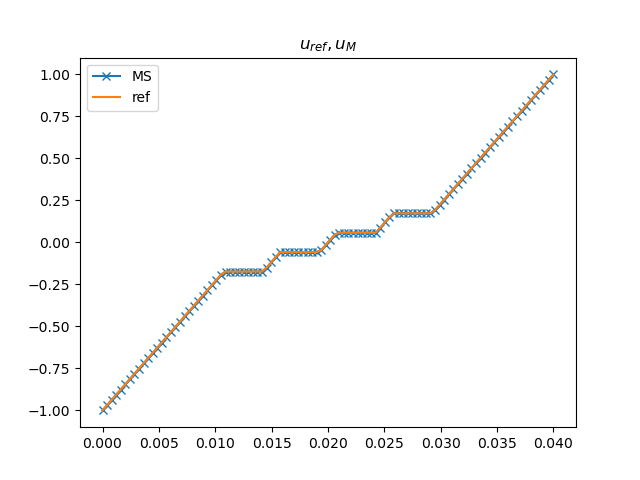

In [10]:

plt.ioff()
start = -d/2*1.01
end = -d/2*0.9

# start = d/2*0.95
# end = d/2*1.02


plt.figure(1)
start = -D/2
end = D/2




evalOnLine(sum(sol_comp_MS) , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=100);
evalOnLine(sol_ref , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 100, title=r"$u_{ref}, u_{M}$");


plt.legend()
plt.show()

In [11]:
energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                definedon=meshMS.Materials("multiscale"))

cl_gradgradMS.gradsol_pack[0][0]                                         

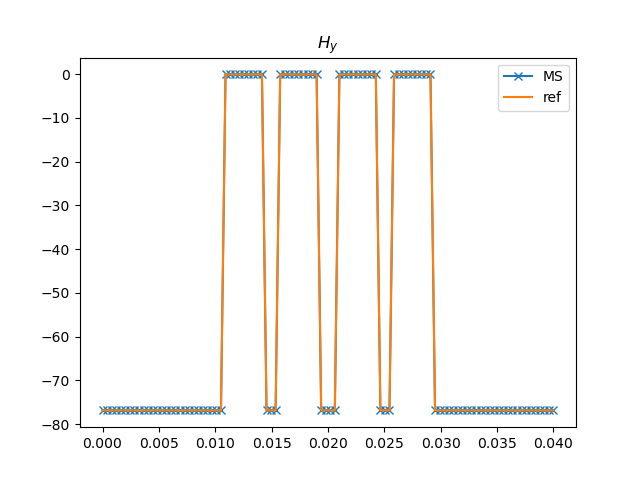

In [12]:
start = -D/2
end = D/2


plt.figure(2)
evalOnLine(sum(H_comp)[1] , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=100, title=r"$H_y$");
evalOnLine(-grad(sol_ref)[1] , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 100, title=r"$H_y$");


plt.legend()
plt.show()

In [13]:
print("Norm soll diff", Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref)




Norm soll diff 4.2060653314721667e-16
diff energy 0.7109501315942591 0.710950131594817 -5.578870698741412e-13
